# Stochastic Volatility Models

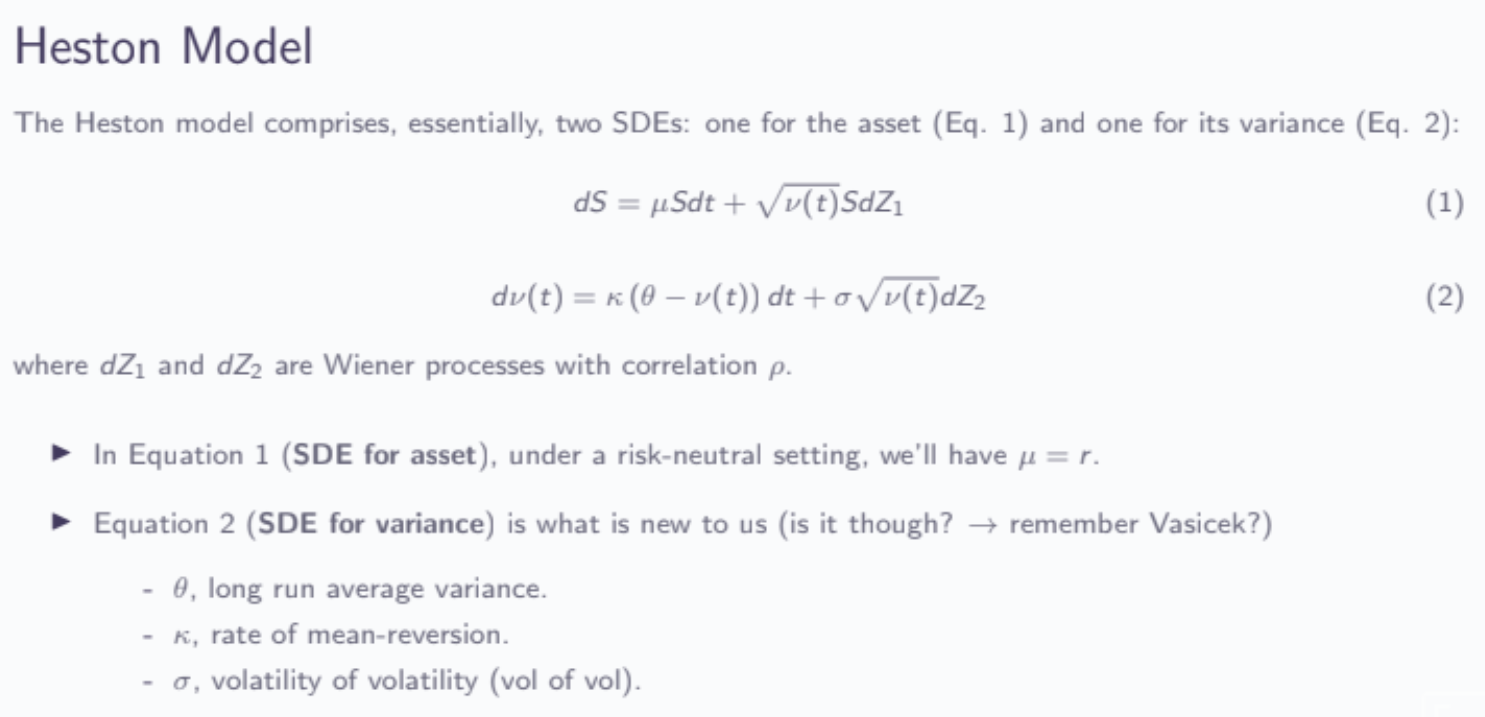

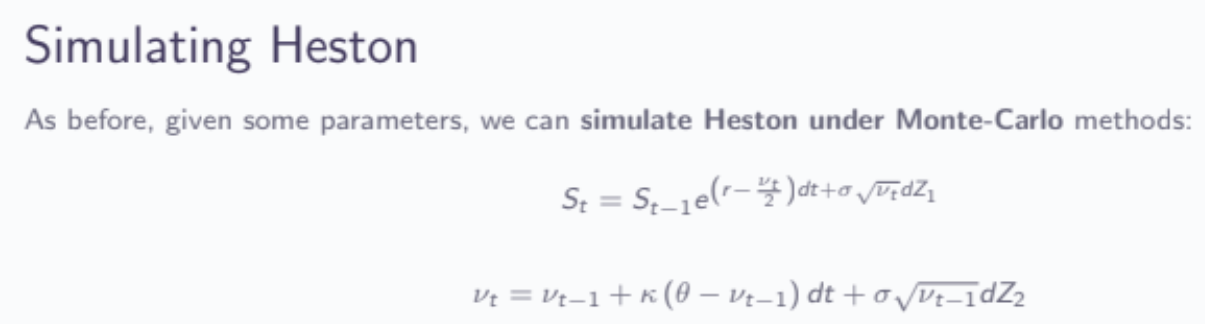

$$
\Large\begin{equation*} 
    S_t = S_{t-1} e^{\left( r - \frac{\nu_t}{2} \right) dt + \sigma \sqrt{\nu_t} dZ_1}
\end{equation*} 
$$
$$
\Large\begin{equation*} 
    \nu_t = \nu_{t-1} + \kappa \left( \theta - \nu_{t-1} \right) dt + \sigma \sqrt{\nu_{t-1}}dZ_2
\end{equation*}
$$

where,

$\theta:$ long-term average variance

$\kappa:$ rate of mean-reversion of the variance

$\sigma:$ volatility of the variance process

# My Try

In [242]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

def gen_dZ(rho, n, T):
    """Generates correlated standard brownian motions dZ1 and dZ2

    Args:
        rho (float): correlation between the "asset brownian motion" dZ1
                    and the "variance brownian motion" dZ2
        n (int): number of timesteps
    """
    dt = T/n
    
    # dZ1 ~ N(0, dt)
    dZ1 = np.random.standard_normal(n) * np.sqrt(dt)  # create the first brownian motion elements, for asset price process
    temp_arr = np.random.standard_normal(n)  # draw independent standard gaussians to use for correlated random variables
    dZ2 = rho * dZ1 + np.sqrt(1 - rho**2) * temp_arr * np.sqrt(dt)  # create the second brownian motion elements, for variance process
    return dZ1, dZ2

def v(v0, kappa, theta, sigma, n, T, dZ2):
    """Calculates the variance process

    Args:
        v0 (float): initial variance value to start from
        kappa (float): parameter for the speed of mean-reversion
        theta (float): long term average of the variance
        dt (float): length of timestep
        sigma (float): volatility of the variance process
        rho (float): correlation between the "asset brownian motion" dZ1
                    and the "variance brownian motion" dZ2
        n (int): number of timesteps to simulate
        T (float): Time at the end of the process to be simulated (maturity date)
        dZ2 (np.array): Standard brownian motion interval values
        which are correlated to dZ1 with rho
    """
    dt = T/n
    v_arr = np.zeros(n)
    v_arr[0] = v0
    # print("v_arr =", v_arr)
    for t in range(1, n):
        v_arr[t] = np.maximum(v_arr[t-1] + kappa * (theta - v_arr[t-1]) * dt + sigma * np.sqrt(v_arr[t-1]) * dZ2[t], 0)
    
    return v_arr

def S(S0, r, sigma, v_arr, T, dZ1):
    """Calculates the asset price process

    Args:
        S0 (float): Initial asset price at start
        r (float): risk-free rate
        sigma (float): volatility of the variance process
        v_arr (np.array): variance process generated by function v()
        T (float): Time at the end of the process to be simulated (maturity date)
        dZ1 (np.array): Standard brownian motion interval values
    """
    n = len(v_arr)
    dt = T/n
    
    S_arr = np.zeros(n)
    S_arr[0] = S0
    for t in range(1, n):
        S_arr[t] = S_arr[t-1] * np.exp((r - v_arr[t]/2)*dt + np.sqrt(v_arr[t])*dZ1[t])
        
    return S_arr

def MC(M, v0, kappa, theta, sigma, n, T, rho, r, S0=None):
    if S0 is None:
        v_MC = np.zeros((M, n))
        for m in range(M):
            dZ1, dZ2 = gen_dZ(rho, n)
            v_MC[m, :] = np.maximum(v(v0, kappa, theta, sigma, n, T, dZ2), 0)
        return v_MC
    else:
        v_MC = np.zeros((M, n))
        S_MC = np.zeros((M, n))
        for m in range(M):
            dZ1, dZ2 = gen_dZ(rho, n, T)
            v_arr = v(v0, kappa, theta, sigma, n, T, dZ2)
            v_MC[m, :] = np.maximum(v_arr, 0)
            S_MC[m, :] = S(S0, r, sigma, v_arr, T, dZ1)
    return v_MC, S_MC

S_MC =
 [[100.         100.01687809 103.74411055 ... 112.99036451 112.44457383
  115.40955848]
 [100.         100.36938651  99.51543729 ...  80.99789808  81.61348613
   81.05036861]
 [100.          99.41357067 101.1563475  ... 106.40831366 104.65552278
  103.83556911]
 ...
 [100.          98.75095435  99.8934095  ... 107.26871053 106.1681592
  105.94317453]
 [100.         104.21450245 105.54128085 ... 105.52001346 104.98172315
  106.73679394]
 [100.         102.21155907 104.53751251 ... 115.35136411 115.79042295
  112.44198982]]


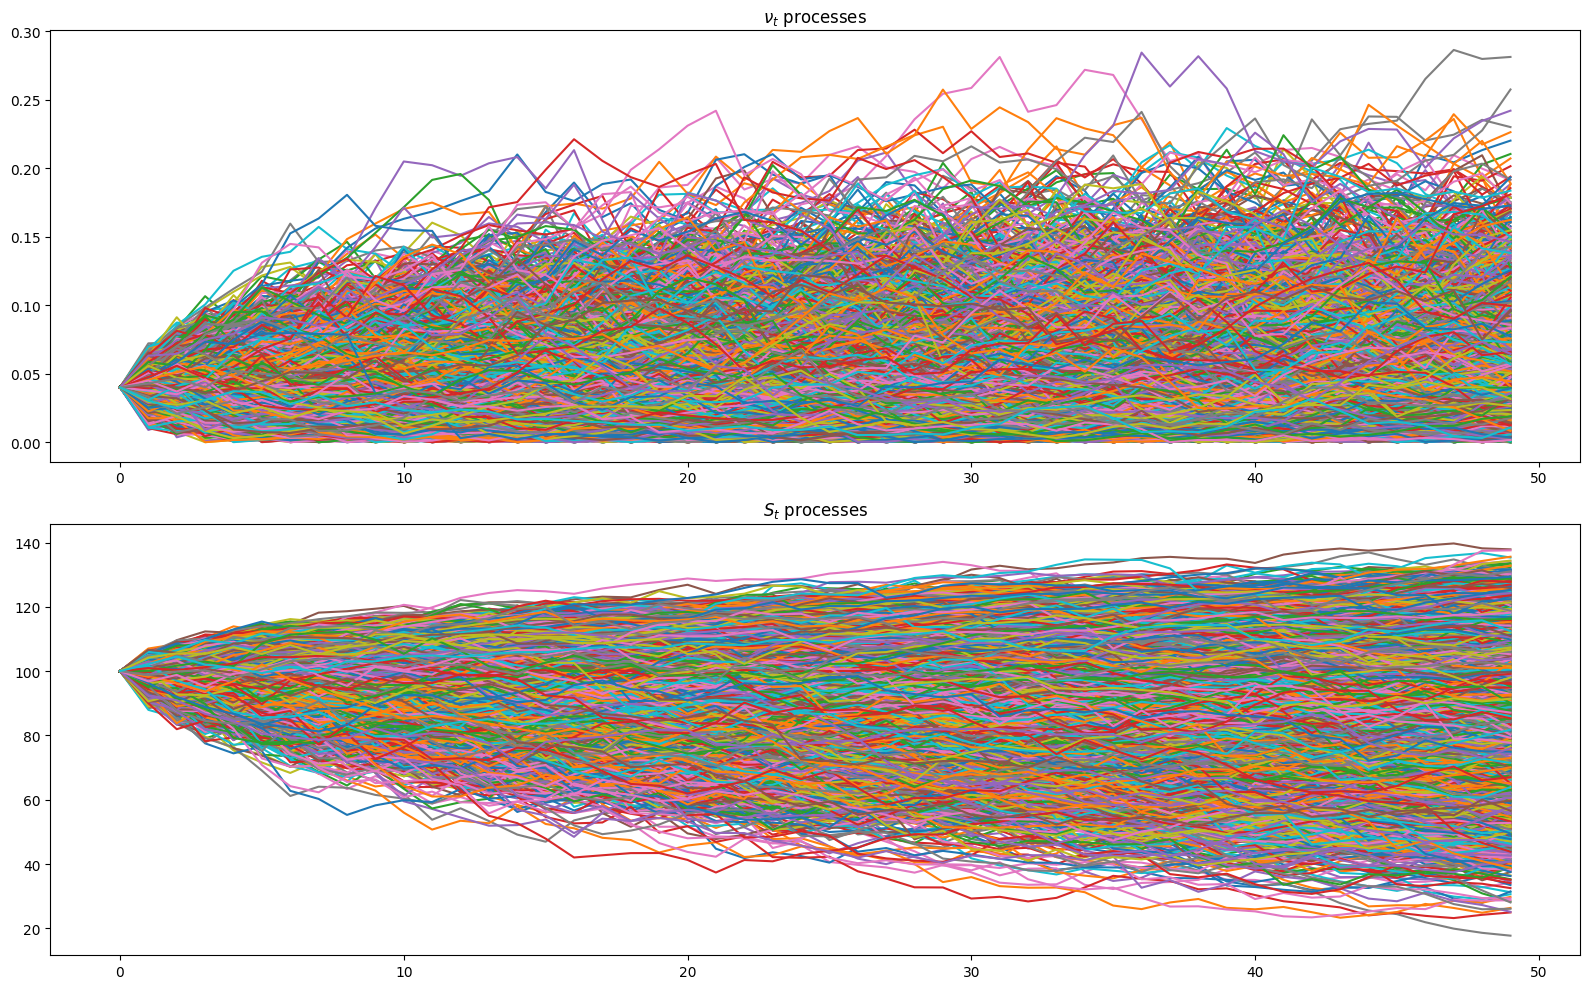

In [243]:
v0 = 0.04
kappa = 2
sigma = 0.3
theta = 0.04
rho = -0.9

S0 = 100  # Current underlying asset price
r = 0.05  # Risk-free rate
M0 = 50  # Number of time steps in a year
T = 1  # Number of years
n = int(M0 * T)  # Total time steps
M = 10000  # Number of simulations

# Simulate
v_MC, S_MC = MC(M, v0, kappa, theta, sigma, n, T, rho, r, S0)

print("S_MC =\n", S_MC)

fig, axs = plt.subplots(2, 1, figsize=(16, 10))
axs[0].plot(v_MC.T)
axs[0].set_title(r"$\nu_t$ processes")
axs[1].plot(S_MC.T)
axs[1].set_title("$S_t$ processes")
fig.tight_layout()

In [244]:
def heston_opt_price_MC(K, t, MC_params, call_or_put="C"):
    M, v0, kappa, theta, sigma, n, T, rho, r, S0 = MC_params
    v_MC, S_MC = MC(M, v0, kappa, theta, sigma, n, T, rho, r, S0)
    if call_or_put == "C":
        payoffs = np.maximum(0, S_MC[:, -1] - K)
    else:
        payoffs = np.maximum(0, K - S_MC[:, -1])
        
    return np.exp(-r * (T-t)) * payoffs.mean()

In [245]:
# MC params
v0 = 0.04
kappa = 2
sigma = 0.3
theta = 0.04
rho = -0.9
S0 = 100  # Current underlying asset price
r = 0.05  # Risk-free rate
M0 = 50  # Number of time steps in a year
T = 1  # Number of years
n = int(M0 * T)  # Total time steps
M = 10000  # Number of simulations

# Option params
K = 90
r = 0.05
t = 0

MC_params = [M, v0, kappa, theta, sigma, n, T, rho, r, S0]

call_price = heston_opt_price_MC(K, t, MC_params, "C")
print("call price =", call_price)

call price = 7.38518627673731


## **2. The Statistical Distribution Produced by Heston**

One important feature of the Heston model is that it produces a distribution of returns that has **heavier tails and kurtosis** than a normal distribution, just as we observe in practice.

In the following code snippet, we will check the Heston-produced distribution on two fronts:

1. Whether **underlying returns** resemble a Normal distribution, as assumed in BS and GBM process.

2. How **volatility** fits a mean-reverting process such as CIR or Vasicek.

_________________

# Merton Jump Diffusion Model

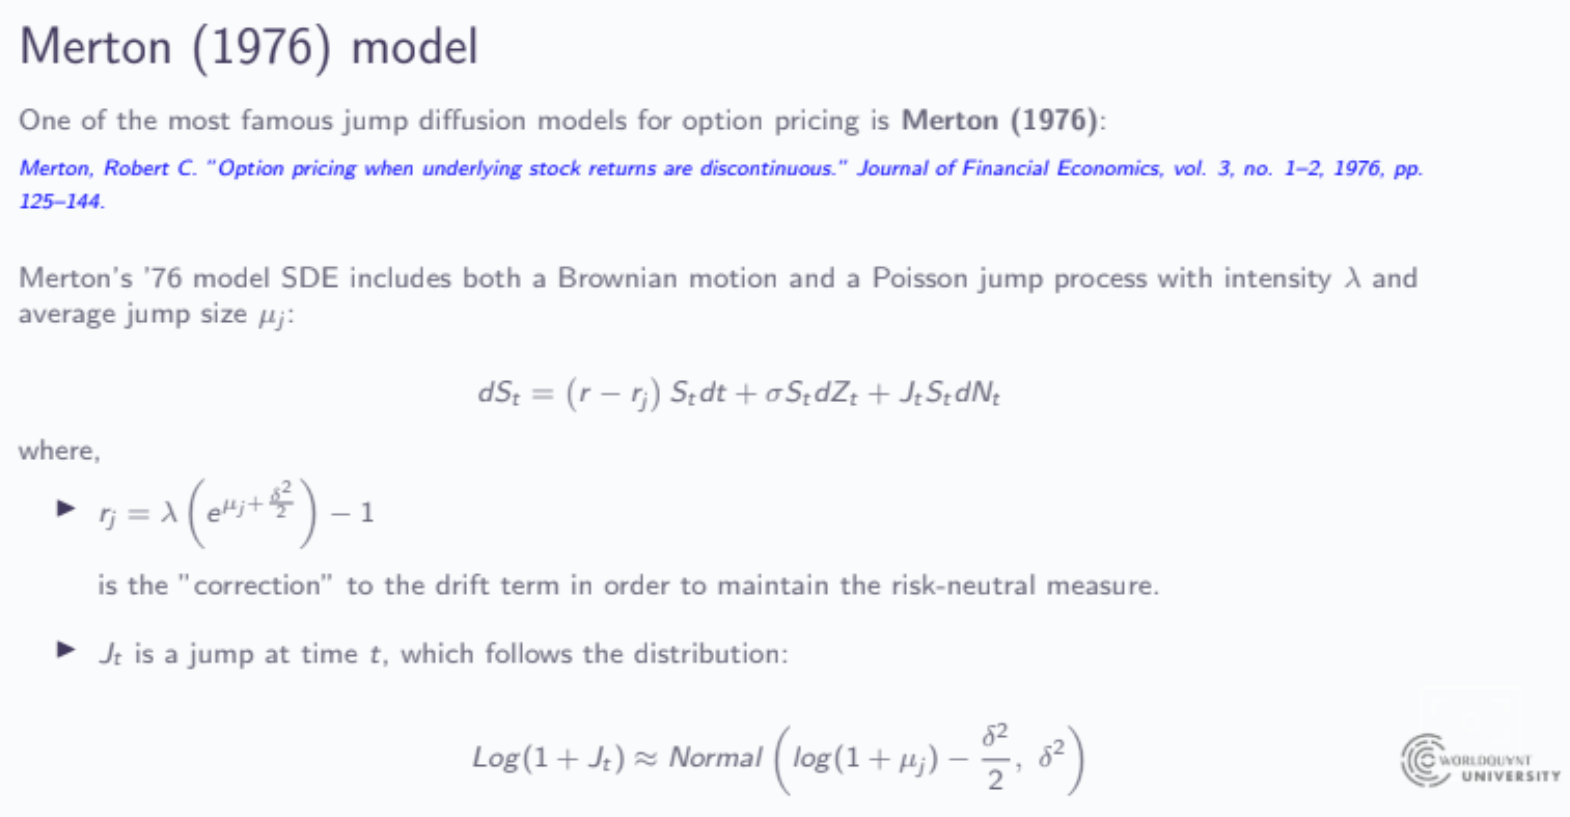

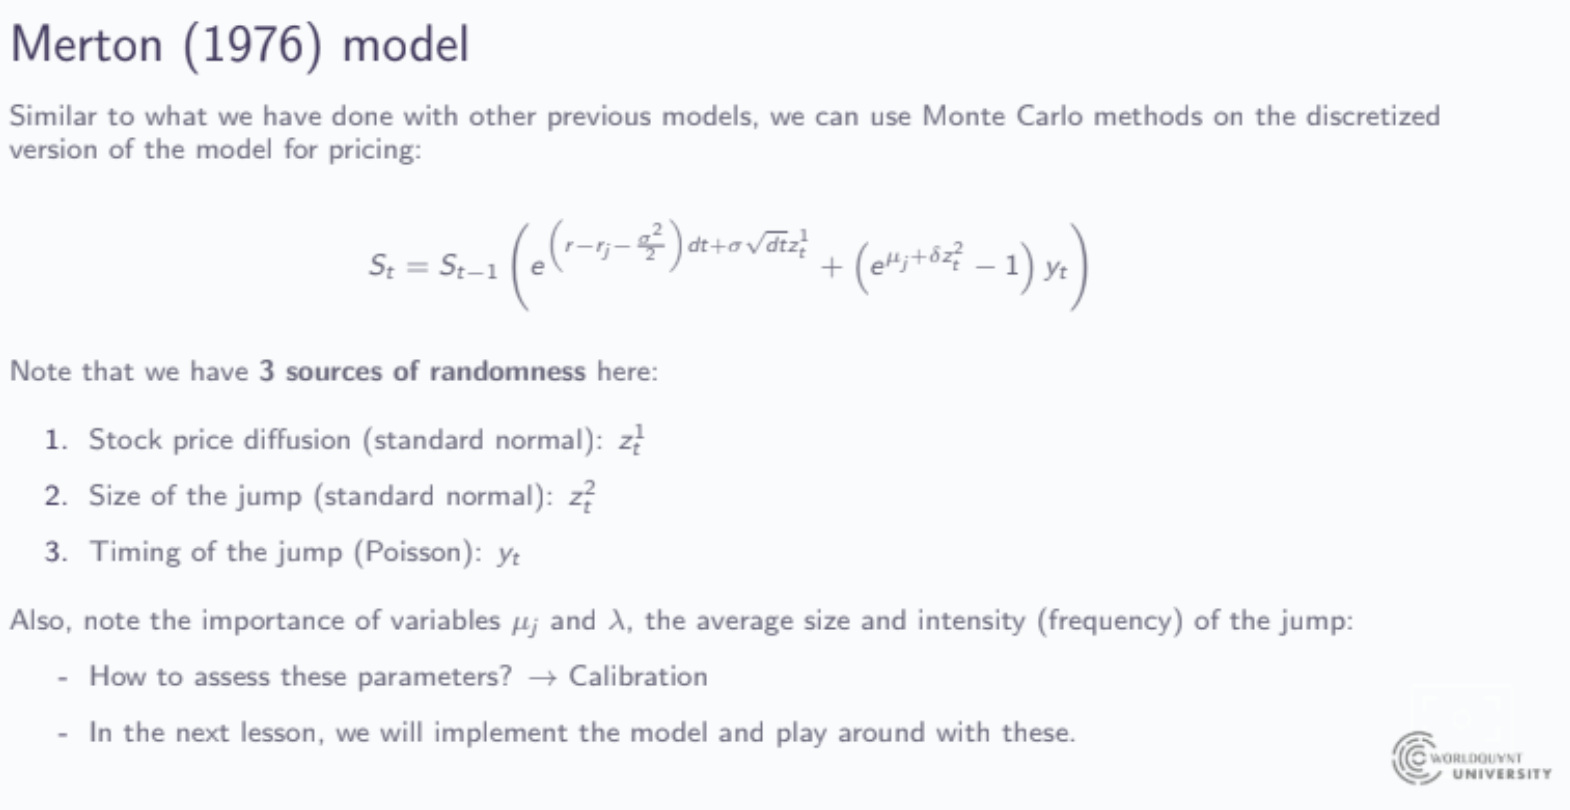

## 1. Implementing the Merton Model

We will start by implementing the Merton model in Python. As you already know, the model has the following SDE:

$$
\begin{equation*}
    dS_t = \left( r - r_j \right) S_t dt + \sigma S_t dZ_t + J_t S_t dN_t
\end{equation*}
$$

with the following discretized form:

$$
\begin{equation*}
    S_t = S_{t-1} \left( e^{\left(r-r_j-\frac{\sigma^2}{2}\right)dt + \sigma \sqrt{dt} z_t^1}+
    \left(e^{\mu_j+\delta z_t^2}-1 \right) y_t \right)
\end{equation*}
$$

where $z_t^1$ and $z_t^2$ follow a standard normal and $y_t$ follows a Poisson process. Finally, $r_j$ equals to:

$$
\begin{equation*}
r_j = \lambda \left(e^{\mu_j+\frac{\delta^2}{2}}\right)-1
\end{equation*}
$$

Remember that, in order to obtain the parameters of the model, we will perform an exercise of calibration to option market prices. This will be, indeed, the first thing we will cover in the following Stochastic Modeling course. For now, let's assume these parameters as given and equal to:

In [246]:
lamb = 0.75  # Lambda of the model
mu = -0.6  # Mu
delta = 0.25  # Delta

r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
T = 1.0  # Maturity/time period (in years)
S0 = 100  # Current Stock Price

M = 10000  # Number of simulations (paths)
n = 50  # Number of steps
dt = T / n  # Time-step